In [1]:
import gzip
import xml
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, spearmanr

# ActD RNA-seq half-life

    在ActD RNA-seq的文件夹中运行

# Benchmark of half-life

## 1. Distribution and correlation with ActD RNA-seq

--------------------------------------------------------------------------------
Name: 1TC
Path: ../../1_NanoNASCseq/results/expression/report/gene_based/K562.treatment_cells.min_read_2_min_tc_1.annotated.tsv
Max half-life: 0
NanoNASC-seq genes: 7505
ActD RNA-seq genes: 6582
NanoNASC-seq and ActD RNA-seq common genes: 5052
Correlation of half-life: 0.373461
Correlation of log2(half-life): 0.702358
Spearman: SpearmanrResult(correlation=0.7245270280320191, pvalue=0.0)
--------------------------------------------------------------------------------
Name: 2TC
Path: ../../1_NanoNASCseq/results/expression/report/gene_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv
Max half-life: 0
NanoNASC-seq genes: 7359
ActD RNA-seq genes: 6582
NanoNASC-seq and ActD RNA-seq common genes: 5011
Correlation of half-life: 0.379234
Correlation of log2(half-life): 0.714101
Spearman: SpearmanrResult(correlation=0.7365453148796621, pvalue=0.0)


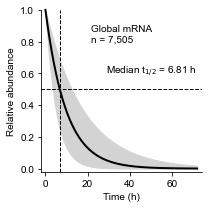

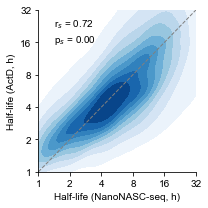

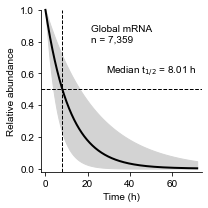

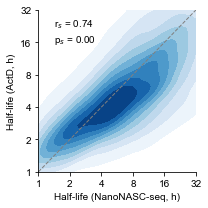

In [3]:
paths = [
    ["1TC", "../../1_NanoNASCseq/results/expression/report/gene_based/K562.treatment_cells.min_read_2_min_tc_1.annotated.tsv"],
    ["2TC", "../../1_NanoNASCseq/results/expression/report/gene_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv"]
]

for name, path in paths:
    for max_ht in [0]: # [0, 24, 32, 40]:
        print("-" * 80)
        print("Name:", name)
        print("Path:", path)
        print("Max half-life:", max_ht)
        
        dat1 = pd.read_csv(path, sep="\t", index_col=0)
        dat1 = dat1[dat1["GeneType"] == "protein_coding"]
        dat1 = dat1[(dat1["Total"] >= 5) & (dat1["Nascent"] >= 1) & (dat1["Total"] > dat1["Nascent"])]
        print("NanoNASC-seq genes: %d" % len(dat1))

        dat2 = pd.read_csv("../../5_RNAseq_ActD/results/halflife/20221128_AtcD_halflife.tsv", sep="\t")
        dat2 = dat2[dat2["GeneType"] == "protein_coding"]
        dat2 = dat2[dat2["Canonical"]]
        dat2 = dat2[~dat2["GeneID"].duplicated()]
        dat2.index = dat2["GeneID"]
        dat2 = dat2[(dat2["0h-1_fpkm"] >= 1) & (dat2["D"] < 0.3)]
        print("ActD RNA-seq genes: %d" % len(dat2))

        if max_ht > 0:
            dat1["T"] = [min(t, max_ht) for t in dat1["T"]]
            dat2["T"] = [min(t, max_ht) for t in dat2["T"]]

        s1 = dat1["T"]
        s1.name = "NanoNASCseq"
        s2 = dat2["T"]
        s2.name = "RNAseq"
        dat3 = pd.concat([s1, s2], axis=1, sort=False, join="inner")
        # dat3 = dat3[dat3.max(axis=1) < 32]
        print("NanoNASC-seq and ActD RNA-seq common genes: %d" % len(dat3))
    
        max_time = 72
        xs = np.arange(0, max_time, 0.1)
        rows = []
        hts = dat1["T"]
        ht = np.median(hts)
        for T in hts:
            ys = [0.5**(x/T) for x in xs]
            rows.append(ys)
        d = pd.DataFrame(rows)
        ys = []
        ys1 = []
        ys2 = []
        for i in d.columns:
            vs = list(sorted(d[i]))
            y = np.median(vs)
            y1 = vs[int(len(vs) * 0.25)]
            y2 = vs[int(len(vs) * 0.75)]
            ys.append(y)
            ys1.append(y1)
            ys2.append(y2)
        plt.figure(figsize=(3, 3))
        plt.plot(xs, ys, color="black", lw=2, clip_on=False)
        plt.fill_between(xs, ys1, ys2, color="lightgrey", clip_on=False)
        plt.text(max_time * 0.4, 0.6, "Median t$_{1/2}$ = %.2f h" % ht)
        plt.text(max_time * 0.3, 0.8, "Global mRNA\nn = %s" % format(len(d), ","))
        plt.axhline(0.5, ls="--", lw=1, color="black")
        plt.axvline(ht, ls="--", lw=1, color="black")
        plt.xlim(0 - 2, max_time + 2)
        plt.ylim(-0.02, 1)
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.xlabel("Time (h)")
        plt.ylabel("Relative abundance")
        plt.tight_layout()
        #plt.show()
        plt.savefig("figures/halflife_distribution_K562.%s.MAXHT%d.pdf" % (name, max_ht), dpi=300)
        #plt.close()
        
        r = np.corrcoef(dat3["NanoNASCseq"], dat3["RNAseq"])[0][1]
        print("Correlation of half-life: %f" % r)

        xs = np.log2(dat3["NanoNASCseq"])
        ys = np.log2(dat3["RNAseq"])
        r = np.corrcoef(xs, ys)[0][1]
        print("Correlation of log2(half-life): %f" % r)
        
        r_p = spearmanr(xs, ys)
        r_s, p_s = r_p
        print("Spearman:", r_p)

        plt.figure(figsize=(3, 3))
        sns.kdeplot(x=xs, y=ys, fill=True, cmap='Blues', cbar=False, alpha=1, zorder=2)
        # plt.scatter(xs, ys, marker="o", s=10, color="blue", alpha=0.1, zorder=1)
        vmin, vmax = 0, 5
        plt.plot([vmin, vmax], [vmin, vmax], lw=1, ls="--", color="grey")
        plt.text(vmin + (vmax - vmin) * 0.1, vmin + (vmax - vmin) * 0.9, "r$_s$ = %.2f" % r_s)
        plt.text(vmin + (vmax - vmin) * 0.1, vmin + (vmax - vmin) * 0.8, "p$_s$ = %.2f" % p_s)
        plt.xlim(vmin, vmax)
        plt.ylim(vmin, vmax)
        plt.xlabel("Half-life (NanoNASC-seq, h)")
        plt.ylabel("Half-life (ActD, h)")
        vs = np.arange(vmin, vmax + 1)
        ticks = [str(2**int(v)) for v in vs]
        plt.xticks(vs, ticks)
        plt.yticks(vs, ticks)
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()
        #plt.show()
        plt.savefig("figures/halflife_correlation_with_actd.%s.MAXHT%d.pdf" % (name, max_ht), dpi=300)
        #plt.close()

## 2. ActD RNA-seq halft-life distribution

In [5]:
dat = pd.read_csv("../../5_RNAseq_ActD/results/halflife/20221128_AtcD_halflife.tsv", sep="\t")
dat = dat[dat["GeneType"] == "protein_coding"]
dat = dat[dat["Canonical"]]
dat = dat[~dat["GeneID"].duplicated()]
dat.index = dat["GeneID"]
dat = dat[(dat["0h-1_fpkm"] >= 1) & (dat["D"] < 0.3)]
print("ActD RNA-seq genes: %d" % len(dat))

if True:
    dat["T"] = [min(t, 32) for t in dat["T"]]

ActD RNA-seq genes: 6582


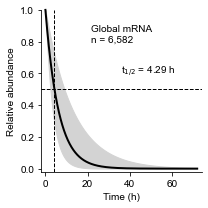

In [6]:
max_time = 72
xs = np.arange(0, max_time, 0.1)
rows = []
hts = dat["T"]
ht = np.median(hts)
for T in hts:
    ys = [0.5**(x/T) for x in xs]
    rows.append(ys)
d = pd.DataFrame(rows)
ys = []
ys1 = []
ys2 = []
for i in d.columns:
    vs = list(sorted(d[i]))
    y = np.median(vs)
    y1 = vs[int(len(vs) * 0.25)]
    y2 = vs[int(len(vs) * 0.75)]
    ys.append(y)
    ys1.append(y1)
    ys2.append(y2)
plt.figure(figsize=(3, 3))
plt.plot(xs, ys, color="black", lw=2, clip_on=False)
plt.fill_between(xs, ys1, ys2, color="lightgrey", clip_on=False)
plt.text(max_time * 0.5, 0.6, "t$_{1/2}$ = %.2f h" % ht)
plt.text(max_time * 0.3, 0.8, "Global mRNA\nn = %s" % format(len(d), ","))
plt.axhline(0.5, ls="--", lw=1, color="black")
plt.axvline(ht, ls="--", lw=1, color="black")
plt.xlim(0 - 2, max_time + 2)
plt.ylim(-0.02, 1)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Time (h)")
plt.ylabel("Relative abundance")
plt.tight_layout()
# plt.show()
plt.savefig("figures/global_mrna_halflife.RNAseq.pdf", dpi=300)

## 3. mESC half-life distribution

--------------------------------------------------------------------------------
Name: 1TC
Path: ../../1_NanoNASCseq/results/expression/report/gene_based/mESC.treatment_cells.min_read_2_min_tc_1.annotated.tsv
NanoNASC-seq genes: 6904


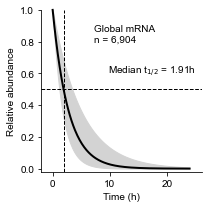

--------------------------------------------------------------------------------
Name: 2TC
Path: ../../1_NanoNASCseq/results/expression/report/gene_based/mESC.treatment_cells.min_read_2_min_tc_2.annotated.tsv
NanoNASC-seq genes: 7305


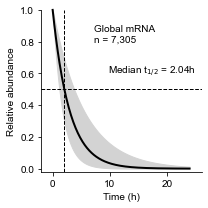

In [7]:
paths = [
    ["1TC", "../../1_NanoNASCseq/results/expression/report/gene_based/mESC.treatment_cells.min_read_2_min_tc_1.annotated.tsv"],
    ["2TC", "../../1_NanoNASCseq/results/expression/report/gene_based/mESC.treatment_cells.min_read_2_min_tc_2.annotated.tsv"]
]

for name, path in paths:
    print("-" * 80)
    print("Name:", name)
    print("Path:", path)
    
    dat1 = pd.read_csv(path, sep="\t", index_col=0)
    dat1 = dat1[dat1["GeneType"] == "protein_coding"]
    dat1 = dat1[(dat1["Total"] >= 5) & (dat1["Nascent"] >= 1) & (dat1["Total"] > dat1["Nascent"])]
    print("NanoNASC-seq genes: %d" % len(dat1))

    if False:
        dat1["T"] = [min(t, 32) for t in dat1["T"]]

    max_time = 24
    xs = np.arange(0, max_time, 0.1)
    rows = []
    hts = dat1["T"]
    ht = np.median(hts)
    for T in hts:
        ys = [0.5**(x/T) for x in xs]
        rows.append(ys)
    d = pd.DataFrame(rows)
    ys = []
    ys1 = []
    ys2 = []
    for i in d.columns:
        vs = list(sorted(d[i]))
        y = np.median(vs)
        y1 = vs[int(len(vs) * 0.25)]
        y2 = vs[int(len(vs) * 0.75)]
        ys.append(y)
        ys1.append(y1)
        ys2.append(y2)
    plt.figure(figsize=(3, 3))
    plt.plot(xs, ys, color="black", lw=2, clip_on=False)
    plt.fill_between(xs, ys1, ys2, color="lightgrey", clip_on=False)
    plt.text(max_time * 0.4, 0.6, "Median t$_{1/2}$ = %.2fh" % ht)
    plt.text(max_time * 0.3, 0.8, "Global mRNA\nn = %s" % format(len(d), ","))
    plt.axhline(0.5, ls="--", lw=1, color="black")
    plt.axvline(ht, ls="--", lw=1, color="black")
    plt.xlim(0 - 2, max_time + 2)
    plt.ylim(-0.02, 1)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlabel("Time (h)")
    plt.ylabel("Relative abundance")
    plt.tight_layout()
    # plt.savefig("figures/halflife_distribution_mESC.%s.MAXHT0.pdf" % name, dpi=300)
    plt.show()
    plt.close()

## 4. Distribution and correlation with ActD RNA-seq (NASC-seq)

--------------------------------------------------------------------------------
Name: GSE128273
Path: ../../2_NASCseq/results/halflife/GSE128273_K562_50uM_3h.tsv
Max half-life: 0
NASC-seq genes: 5165
ActD RNA-seq genes: 6582
NASC-seq and ActD RNA-seq common genes: 3488
Correlation of half-life: 0.493910
Correlation of log2(half-life): 0.785149
Spearman: SpearmanrResult(correlation=0.8053098155872662, pvalue=0.0)
--------------------------------------------------------------------------------
Name: NASC-seq
Path: ../../2_NASCseq/results/halflife/NASC-seq_K562_50uM_3h.tsv
Max half-life: 0
NASC-seq genes: 5796
ActD RNA-seq genes: 6582
NASC-seq and ActD RNA-seq common genes: 4043
Correlation of half-life: 0.516362
Correlation of log2(half-life): 0.812827
Spearman: SpearmanrResult(correlation=0.8365475891203223, pvalue=0.0)


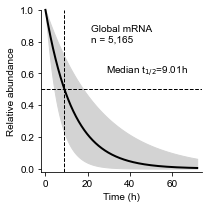

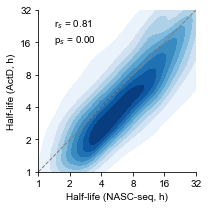

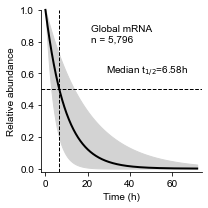

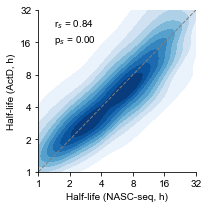

In [43]:
paths = [
    ["GSE128273", "../../2_NASCseq/results/halflife/GSE128273_K562_50uM_3h.tsv"],
    ["NASC-seq", "../../2_NASCseq/results/halflife/NASC-seq_K562_50uM_3h.tsv"]
]

for name, path in paths:
    for max_ht in [0]: # [0, 24, 32, 40]:
        print("-" * 80)
        print("Name:", name)
        print("Path:", path)
        print("Max half-life:", max_ht)
        
        dat1 = pd.read_csv(path, sep="\t", index_col=0)
        dat1 = dat1[dat1["GeneType"] == "protein_coding"]
        dat1 = dat1[dat1["Canonical"]]
        dat1 = dat1[~dat1["GeneID"].duplicated()]
        dat1.index = dat1["GeneID"]
        dat1 = dat1[(dat1["FPKM"] >= 1) & (dat1["FPKM[Nascent]"] >= 1) & (dat1["Count"] > dat1["Count[Nascent]"])]
        print("NASC-seq genes: %d" % len(dat1))

        dat2 = pd.read_csv("../../4_RNAseq_ActD/results/halflife/20221128_AtcD_halflife.tsv", sep="\t")
        dat2 = dat2[dat2["GeneType"] == "protein_coding"]
        dat2 = dat2[dat2["Canonical"]]
        dat2 = dat2[~dat2["GeneID"].duplicated()]
        dat2.index = dat2["GeneID"]
        dat2 = dat2[(dat2["0h-1_fpkm"] >= 1) & (dat2["D"] < 0.3)]
        print("ActD RNA-seq genes: %d" % len(dat2))

        if max_ht > 0:
            dat1["T"] = [min(t, max_ht) for t in dat1["T"]]
            dat2["T"] = [min(t, max_ht) for t in dat2["T"]]

        s1 = dat1["T"]
        s1.name = "NASCseq"
        s2 = dat2["T"]
        s2.name = "RNAseq"
        dat3 = pd.concat([s1, s2], axis=1, sort=False, join="inner")
        # dat3 = dat3[dat3.max(axis=1) < 32]
        print("NASC-seq and ActD RNA-seq common genes: %d" % len(dat3))
    
        max_time = 72
        xs = np.arange(0, max_time, 0.1)
        rows = []
        hts = dat1["T"]
        ht = np.median(hts)
        for T in hts:
            ys = [0.5**(x/T) for x in xs]
            rows.append(ys)
        d = pd.DataFrame(rows)
        ys = []
        ys1 = []
        ys2 = []
        for i in d.columns:
            vs = list(sorted(d[i]))
            y = np.median(vs)
            y1 = vs[int(len(vs) * 0.25)]
            y2 = vs[int(len(vs) * 0.75)]
            ys.append(y)
            ys1.append(y1)
            ys2.append(y2)
        plt.figure(figsize=(3, 3))
        plt.plot(xs, ys, color="black", lw=2, clip_on=False)
        plt.fill_between(xs, ys1, ys2, color="lightgrey", clip_on=False)
        plt.text(max_time * 0.4, 0.6, "Median t$_{1/2}$=%.2fh" % ht)
        plt.text(max_time * 0.3, 0.8, "Global mRNA\nn = %s" % format(len(d), ","))
        plt.axhline(0.5, ls="--", lw=1, color="black")
        plt.axvline(ht, ls="--", lw=1, color="black")
        plt.xlim(0 - 2, max_time + 2)
        plt.ylim(-0.02, 1)
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.xlabel("Time (h)")
        plt.ylabel("Relative abundance")
        plt.tight_layout()
        # plt.show()
        plt.savefig("figures/halflife_distribution_K562.%s.MAXHT%d.pdf" % (name, max_ht), dpi=300)
        #plt.close()
        
        r = np.corrcoef(dat3["NASCseq"], dat3["RNAseq"])[0][1]
        print("Correlation of half-life: %f" % r)

        xs = np.log2(dat3["NASCseq"])
        ys = np.log2(dat3["RNAseq"])
        r = np.corrcoef(xs, ys)[0][1]
        print("Correlation of log2(half-life): %f" % r)
        
        r_p = spearmanr(xs, ys)
        r_s, p_s = r_p
        print("Spearman:", r_p)

        plt.figure(figsize=(3, 3))
        sns.kdeplot(x=xs, y=ys, fill=True, cmap='Blues', cbar=False, alpha=1, zorder=2)
        # plt.scatter(xs, ys, marker="o", s=10, color="blue", alpha=0.1, zorder=1)
        vmin, vmax = 0, 5
        plt.plot([vmin, vmax], [vmin, vmax], lw=1, ls="--", color="grey")
        plt.text(vmin + (vmax - vmin) * 0.1, vmin + (vmax - vmin) * 0.9, "r$_s$ = %.2f" % r_s)
        plt.text(vmin + (vmax - vmin) * 0.1, vmin + (vmax - vmin) * 0.8, "p$_s$ = %.2f" % p_s)
        plt.xlim(vmin, vmax)
        plt.ylim(vmin, vmax)
        plt.xlabel("Half-life (NASC-seq, h)")
        plt.ylabel("Half-life (ActD, h)")
        vs = np.arange(vmin, vmax + 1)
        ticks = [str(2**int(v)) for v in vs]
        plt.xticks(vs, ticks)
        plt.yticks(vs, ticks)
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.tight_layout()
        # plt.show()
        plt.savefig("figures/halflife_correlation_with_actd.%s.MAXHT%d.pdf" % (name, max_ht), dpi=300)
        #plt.close()

# Benchmark of function genes half-life

    GO term

In [44]:
anno = pd.read_csv(gzip.open("/home/chenzonggui/data/go_term/goa_human.gaf.gz"), comment="!", sep="\t", header=None)

/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
goid2gname = defaultdict(list)
for gname, goid in anno[[2, 4]].values:
    goid2gname[goid].append(gname)

In [46]:
db = dict()

array = []
with open("/home/chenzonggui/data/go_term/go.obo") as f:
    lines = None
    for line in f:
        line = line.strip("\n")
        if line.startswith("[Term]"):
            lines = []
        elif line == "":
            if lines is not None:
                array.append(lines)
                lines = None
        else:
            if lines is not None:
                lines.append(line)

In [47]:
terms = dict()
relations = defaultdict(list)
for lines in array:
    term = dict()
    for line in lines:
        i = line.find(":")
        k = line[:i]
        v = line[i + 2:]
        if k == "id":
            term[k] = v
        elif k == "name":
            term[k] = v
        elif k == "namespace":
            term[k] = v
        elif k == "def":
            term[k] = v
        elif k == "is_a":
            relations[v.split()[0]].append(term["id"])
    term["lines"] = lines
    terms[term["id"]] = term
    # break

In [48]:
for term in terms.values():
    if term["name"] == "regulation of transcription by RNA polymerase II":
        print(term)

{'id': 'GO:0006357', 'name': 'regulation of transcription by RNA polymerase II', 'namespace': 'biological_process', 'def': '"Any process that modulates the frequency, rate or extent of transcription mediated by RNA polymerase II." [GOC:go_curators, GOC:txnOH]', 'lines': ['id: GO:0006357', 'name: regulation of transcription by RNA polymerase II', 'namespace: biological_process', 'alt_id: GO:0006358', 'alt_id: GO:0010551', 'def: "Any process that modulates the frequency, rate or extent of transcription mediated by RNA polymerase II." [GOC:go_curators, GOC:txnOH]', 'synonym: "global transcription regulation from Pol II promoter" RELATED []', 'synonym: "regulation of gene-specific transcription from RNA polymerase II promoter" RELATED []', 'synonym: "regulation of global transcription from Pol II promoter" RELATED []', 'synonym: "regulation of transcription from Pol II promoter" EXACT []', 'synonym: "regulation of transcription from RNA polymerase II promoter" EXACT []', 'synonym: "regulat

In [59]:
if True:
    dat = pd.read_csv("../../1_NanoNASCseq/results/expression/report/gene_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t", index_col=0)
    dat = dat[dat["GeneType"] == "protein_coding"]
    dat = dat[(dat["Total"] >= 5) & (dat["Nascent"] >= 1) & (dat["Total"] > dat["Nascent"])]
    dat = dat[~dat["GeneName"].duplicated()]
    dat.index = dat["GeneName"]
else:
    dat = pd.read_csv("../../4_RNAseq_ActD/results/halflife/20221128_AtcD_halflife.tsv", sep="\t")
    dat = dat[dat["GeneType"] == "protein_coding"]
    dat = dat[dat["Canonical"]]
    dat = dat[~dat["GeneName"].duplicated()]
    dat.index = dat["GeneName"]
    dat = dat[(dat["0h-1_fpkm"] >= 1) & (dat["D"] < 0.3)]

In [60]:
def extend(goid):
    for v in relations[goid]:
        yield v
        for v1 in extend(v):
            yield v1
            
def get_gnames(goids):
    gnames = set()
    for goid in goids:
        for gname in goid2gname[goid]:
            gnames.add(gname)
    return gnames

def get_half_life(gnames):
    gnames = gnames & set(dat.index)
    return list(dat.loc[gnames]["T"])

In [61]:
median = np.median(dat["T"])
print(median)

8.012916505559206


In [74]:
goid2gname["GO:0043248"]

['PSMD11',
 'ADRM1',
 'PSMG4',
 'ECPAS',
 'OTUD6B',
 'PSMG3',
 'POMP',
 'PSMG2',
 'POMP']

In [76]:
goid2gname["GO:0070682"]

['PSMD9', 'PSMD10', 'PSMD5', 'PSMD9']

In [72]:
list(extend("GO:0043248"))

['GO:0070682', 'GO:0080129']

In [73]:
list(extend("GO:0090364"))

['GO:0090363']

--------------------------------------------------------------------------------
GO:2001141	Transcription	664	3453	1431
T-test of halflife: 7.534889800516188e-15
T-test of halflife (log2): 3.0584166237042365e-32
--------------------------------------------------------------------------------
GO:0009966	Transduction	2343	2945	1132
T-test of halflife: 0.005253043046927106
T-test of halflife (log2): 0.01733900542977651
--------------------------------------------------------------------------------
GO:0051726	Cell cycle	2258	1104	647
T-test of halflife: 0.0026603146367007724
T-test of halflife (log2): 2.6419121556160366e-05
--------------------------------------------------------------------------------
GO:0045595	Differentiation	2485	1529	503
T-test of halflife: 0.037533871720653
T-test of halflife (log2): 0.0008229515238970551
--------------------------------------------------------------------------------
GO:0004672	Kinases	167	580	245
T-test of halflife: 0.0029716244395709595
T-test o

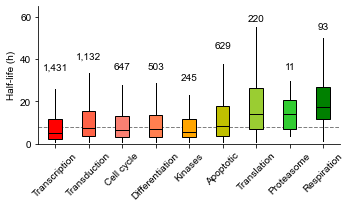

In [104]:
from scipy.stats import ttest_ind

a = {
    "GO:2001141": ["Transcription", "regulation of RNA biosynthetic process"],
    "GO:0009966": ["Transduction", "regulation of signal transduction"],
    "GO:0051726": ["Cell cycle", "regulation of cell cycle"],
    "GO:0045595": ["Differentiation", "regulation of cell differentiation"],
    "GO:0004672": ["Kinases", "protein kinase activity"],
    "GO:0042981": ["Apoptotic", "regulation of apoptotic process"],
    "GO:0006412": ["Translation", "translation"],
    "GO:0043248": ["Proteasome", "proteasome assembly"],
    "GO:0045333": ["Respiration", "cellular respiration"]
}
ks = list(a.keys())
xs = np.arange(len(ks))
ticks = [a[goid][0] for goid in ks]
colors = ["red", "tomato", "salmon", "coral", "orange", "y", "yellowgreen", "limegreen", "green"]
ys_text = [35, 40, 35, 35, 30, 45, 58, 35, 54]
plt.figure(figsize=(5, 3))
for i, goid in enumerate(ks):
    print("-" * 80)
    goids = [goid] + list(extend(goid))
    gnames = get_gnames(goids)
    vs = get_half_life(gnames)
    print(goid, a[goid][0], len(goids), len(gnames), len(vs), sep="\t")
    print("T-test of halflife:", ttest_ind(vs, dat["T"])[1])
    print("T-test of halflife (log2):", ttest_ind(np.log2(vs), np.log2(dat["T"]))[1])
    plt.boxplot([vs], positions=[i], showfliers=False, showcaps=False, 
                widths=0.4, 
                patch_artist=True, boxprops={"facecolor": colors[i]}, 
                medianprops={"color": "black"})
    plt.text(i, ys_text[i], "%s" % format(len(vs), ","), ha="center")
plt.axhline(median, lw=1, ls="--", color="grey")
plt.xticks(xs, ticks, rotation=45)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 65)
# plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.xlabel("")
plt.ylabel("Half-life (h)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/go_term_halflife.pdf", dpi=300)

# miRNA target and m6A target (mESC)

In [8]:
dat1 = pd.read_csv("../../1_NanoNASCseq/results/expression/report/gene_based/mESC.treatment_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t", index_col=0)
dat1 = dat1[dat1["GeneType"] == "protein_coding"]
dat1 = dat1[(dat1["Total"] >= 10) & (dat1["Nascent"] >= 1) & (dat1["Total"] > dat1["Nascent"])]
print("NanoNASC-seq genes: %d" % len(dat1))

NanoNASC-seq genes: 6288


## 1. miRNA targets

In [10]:
dat2 = pd.read_excel("data/TargetScan8.0__miR-291-3p_294-3p_295-3p_302-3p.predicted_targets.xlsx")
targets1 = set(dat2["Target gene"])

dat2 = pd.read_excel("data/TargetScan8.0__miR-291-5p.predicted_targets.xlsx")
targets2 = set(dat2["Target gene"])

targets = targets1 | targets2
targets2 = targets2 - targets1
print(len(targets1), len(targets2))

d1 = dat1[[gname in targets1 for gname in dat1["GeneName"]]]
d2 = dat1[[gname in targets2 for gname in dat1["GeneName"]]]
d3 = dat1[[gname not in targets for gname in dat1["GeneName"]]]
print("Targets1:", len(d1))
print("Targets2:", len(d2))
print("No target:", len(d3))

766 4668
Targets1: 235
Targets2: 1565
No target: 4488


1.887379141862766e-15
8.880363111529732e-11


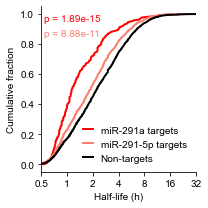

In [12]:
def get_xy(vs):
    vs = list(sorted(vs))
    xs = vs
    ys = np.arange(len(xs)) / len(xs)
    return xs, ys

xs1, ys1 = get_xy(np.log2(d1["T"]))
xs2, ys2 = get_xy(np.log2(d2["T"]))
xs3, ys3 = get_xy(np.log2(d3["T"]))
p1 = ks_2samp(xs1, xs3)[1]
p2 = ks_2samp(xs2, xs3)[1]

print(p1)
print(p2)

vmin, vmax = -1, 5
plt.figure(figsize=(3, 3))
plt.plot(xs1, ys1, color="red", lw=2, label="miR-291a targets")
plt.plot(xs2, ys2, color="salmon", lw=2, label="miR-291-5p targets")
plt.plot(xs3, ys3, color="black", lw=2, label="Non-targets")

plt.text(vmin + (vmax - vmin) * 0.02, 0.95, "p = %.2e" % p1, color="red")
plt.text(vmin + (vmax - vmin) * 0.02, 0.85, "p = %.2e" % p2, color="salmon")

plt.xlabel("Half-life (h)")
plt.ylabel("Cumulative fraction")
xs = np.arange(vmin, vmax + 1)
plt.xticks(xs, [str(2**int(x)) for x in xs])
plt.xlim(vmin, vmax)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("figures/benchmark_halflife_mESC_miR291a_target.pdf", dpi=300)

house keeping genes: https://www.nature.com/articles/s41598-020-78863-5

70
House keeping: 53
Other: 6235
2.7653670797711527e-06


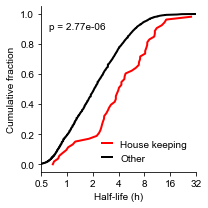

In [6]:
dat2 = pd.read_excel("data/mouse_house_keeping_genes_70.xlsx")
targets = set(dat2["Symbol"])
print(len(targets))

d1 = dat1[[gname in targets for gname in dat1["GeneName"]]]
d2 = dat1[[gname not in targets for gname in dat1["GeneName"]]]
print("House keeping:", len(d1))
print("Other:", len(d2))

def get_xy(vs):
    vs = list(sorted(vs))
    xs = vs
    ys = np.arange(len(xs)) / len(xs)
    return xs, ys

xs1, ys1 = get_xy(np.log2(d1["T"]))
xs2, ys2 = get_xy(np.log2(d2["T"]))
p = ks_2samp(xs1, xs2)[1]
print(p)

vmin, vmax = -1, 5
plt.figure(figsize=(3, 3))
plt.plot(xs1, ys1, color="red", lw=2, label="House keeping")
plt.plot(xs2, ys2, color="black", lw=2, label="Other")
plt.text(vmin + (vmax - vmin) * 0.05, 0.9, "p = %.2e" % p)
plt.xlabel("Half-life (h)")
plt.ylabel("Cumulative fraction")
xs = np.arange(vmin, vmax + 1)
plt.xticks(xs, [str(2**int(x)) for x in xs])
plt.xlim(vmin, vmax)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("figures/benchmark_halflife_mESC_house_keeping_genes.pdf", dpi=300)

## 2. m6A targets

In [13]:
dat2 = pd.read_excel("data/m6A_targets_in_mESC_mm9.xlsx")
targets = set(dat2["Gene Symbol"])
len(targets)

d1 = dat1[[gname in targets for gname in dat1["GeneName"]]]
d2 = dat1[[gname not in targets for gname in dat1["GeneName"]]]
print("m6A targets:", len(d1))
print("No m6A targets:", len(d2))

m6A targets: 2873
No m6A targets: 3415


4.6629367034256575e-15


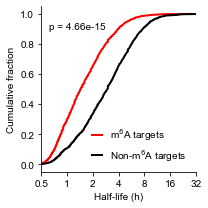

In [14]:
def get_xy(vs):
    vs = list(sorted(vs))
    xs = vs
    ys = np.arange(len(xs)) / len(xs)
    return xs, ys

xs1, ys1 = get_xy(np.log2(d1["T"]))
xs2, ys2 = get_xy(np.log2(d2["T"]))
p = ks_2samp(xs1, xs2)[1]
print(p)

vmin, vmax = -1, 5
plt.figure(figsize=(3, 3))
plt.plot(xs1, ys1, color="red", lw=2, label="m$^6$A targets")
plt.plot(xs2, ys2, color="black", lw=2, label="Non-m$^6$A targets")
plt.text(vmin + (vmax - vmin) * 0.05, 0.9, "p = %.2e" % p)
plt.xlabel("Half-life (h)")
plt.ylabel("Cumulative fraction")
xs = np.arange(vmin, vmax + 1)
plt.xticks(xs, [str(2**int(x)) for x in xs])
plt.xlim(vmin, vmax)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("figures/benchmark_halflife_mESC_m6a_target.pdf", dpi=300)

In [15]:
dat2 = pd.read_excel("data/m6A_targets_in_mESC_mm9.xlsx")
targets = set(dat2["Gene Symbol"])
targets1 = set(dat2[dat2["Position"] == "5UTR"]["Gene Symbol"])
targets2 = set(dat2[dat2["Position"] == "CDS"]["Gene Symbol"])
targets3 = set(dat2[dat2["Position"] == "3UTR"]["Gene Symbol"])
targets1 = targets1 - targets2 - targets3
targets3 = targets3 - targets2
len(targets), len(targets1), len(targets2), len(targets3)

(5578, 79, 2102, 1543)

47 930 863 3415
8.803853459582456e-07 5.136911149998229e-169 1.8036094238080215e-54


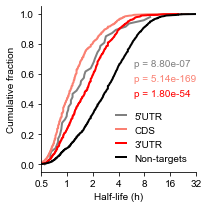

In [27]:
d1 = dat1[[gname in targets1 for gname in dat1["GeneName"]]]
d2 = dat1[[gname in targets2 for gname in dat1["GeneName"]]]
d3 = dat1[[gname in targets3 for gname in dat1["GeneName"]]]
d4 = dat1[[gname not in targets for gname in dat1["GeneName"]]]
print(len(d1), len(d2), len(d3), len(d4))

xs1, ys1 = get_xy(np.log2(d1["T"]))
xs2, ys2 = get_xy(np.log2(d2["T"]))
xs3, ys3 = get_xy(np.log2(d3["T"]))
xs4, ys4 = get_xy(np.log2(d4["T"]))

p1 = ks_2samp(xs1, xs4)[1]
p2 = ks_2samp(xs2, xs4)[1]
p3 = ks_2samp(xs3, xs4)[1]
print(p1, p2, p3)

vmin, vmax = -1, 5
plt.figure(figsize=(3, 3))
plt.plot(xs1, ys1, color="grey", lw=2, label="5'UTR")
plt.plot(xs2, ys2, color="salmon", lw=2, label="CDS")
plt.plot(xs3, ys3, color="red", lw=2, label="3'UTR")
plt.plot(xs4, ys4, color="black", lw=2, label="Non-targets")
plt.text(vmin + (vmax - vmin) * 0.6, 0.65, "p = %.2e" % p1, color="grey")
plt.text(vmin + (vmax - vmin) * 0.6, 0.55, "p = %.2e" % p2, color="salmon")
plt.text(vmin + (vmax - vmin) * 0.6, 0.45, "p = %.2e" % p3, color="red")

plt.xlabel("Half-life (h)")
plt.ylabel("Cumulative fraction")
xs = np.arange(vmin, vmax + 1)
plt.xticks(xs, [str(2**int(x)) for x in xs])
plt.xlim(vmin, vmax)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("figures/benchmark_halflife_mESC_m6a_target_detail.pdf", dpi=300)